In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from tqdm import tqdm
import scipy.optimize as optimize
import scipy.constants

Λ_cutoff = 5000
Nc = 3
mσ = 599.99
mq = 300
mπ = 139.57039
fπ = 133/np.sqrt(2)
g = mq/fπ

def C(p):
    return np.real(2-2*np.emath.sqrt(4*mq**2/(p**2)-1)*np.arctan(1/(np.emath.sqrt(4*mq**2/(p**2)-1))))

def dC(p):
    return np.real(4*mq**2/(p**4*np.emath.sqrt(4*mq**2/(p**2)-1))*np.arctan(1/(np.emath.sqrt(4*mq**2/(p**2)-1)))-1/(p**2))

Cσ = C(mσ)
Cπ = C(mπ)
dCπ = dC(mπ)

def E(p, m):
    return np.sqrt(p**2 + m**2)

def EΔ(p, m, Δ, μ_bar):  
    return np.sqrt((E(p, m) + μ_bar)**2 + Δ**2)

def step(x):
    if x >= 0:
        return 1
    else:
        return 0



In [2]:
def Ωϕρ(ϕ, ρ, μI):
    line1 = 3/4*mπ**2*fπ**2*(1 - 4*mq**2*Nc/((4*np.pi)**2*fπ**2)*mπ**2*dCπ)*(ϕ**2 + ρ**2)/(mq**2)
    line2 = -1/4*mσ**2*fπ**2*(1 + 4*mq**2*Nc/((4*np.pi)**2*fπ**2)*((1-4*mq**2/(mσ**2))*Cσ + 4*mq**2/(mσ**2) - Cπ - mπ**2*dCπ))*(ϕ**2 + ρ**2)/(mq**2)
    line3 = -μI**2/2*fπ**2*(1 - 4*mq**2*Nc/((4*np.pi)**2*fπ**2)*(np.log((ϕ**2 + ρ**2)/(mq**2) + Cπ + mπ**2*dCπ)))*ρ**2/(mq**2)
    line4 = 1/8*mσ**2*fπ**2*(1 - 4*mq**2*Nc/((4*np.pi)**2*fπ**2)*(4*mq**2/(mσ**2)*(np.log((ϕ**2 + ρ**2)/(mq**2)) - 3/2) - (1 - 4*mq**2/(mσ**2))*Cσ + Cπ + mπ**2*dCπ))*(ϕ**2 + ρ**2)**2/(mq**4)
    line5 = -1/8*mπ**2*fπ**2*(1 - 4*mq**2*Nc/((4*np.pi)**2*fπ**2)*mπ**2*dCπ)*(ϕ**2 + ρ**2)**2/(mq**4) - mπ**2*fπ**2*(1 - 4*mq**2*Nc/((4*np.pi)**2*fπ**2)*mπ**2*dCπ)*ϕ/mq
    return line1 + line2 + line3 + line4 + line5

def Ωϕρ_finite(ϕ, ρ, μI):
    def integrand(p):
        return p**2*(np.sqrt((E(p, ϕ) + μI/2)**2 + ρ**2) + np.sqrt((E(p, ϕ) - μI/2)**2 + ρ**2)
                    -2*np.sqrt(p**2 + ϕ**2 + ρ**2)
                    -1/4*μI**2*ρ**2/(p**2 + ϕ**2 + ρ**2)**(3/2))
    integral, err = integrate.quad(integrand, 0, Λ_cutoff)
    return -2*Nc*integral*4*np.pi/((2*np.pi)**3)

def Ωϕρμ(ϕ, ρ, μ, μI):
    def integrand1(p):
        return p**2*((μ - np.sqrt((E(p, ϕ) + 1/2*μI)**2 + ρ**2))*step(μ - np.sqrt((E(p, ϕ) + 1/2*μI)**2 + ρ**2)))
    
    def integrand2(p):
        return p**2*((μ - np.sqrt((E(p, ϕ) - 1/2*μI)**2 + ρ**2))*step(μ - np.sqrt((E(p, ϕ) - 1/2*μI)**2 + ρ**2)))
    
    integral1, err1 = integrate.quad(integrand1, 0, Λ_cutoff)
    
    integral2, err2 = integrate.quad(integrand2, 0, Λ_cutoff)
    
    return -2*Nc*(integral1 + integral2)*4*np.pi/((2*np.pi)**3)

def Ωϕρ_tot(ϕρ, μ, μI):
    ϕ, ρ = ϕρ
    return (Ωϕρ(ϕ, ρ, μI) + Ωϕρ_finite(ϕ, ρ, μI) + Ωϕρμ(ϕ, ρ, μ, μI))

In [3]:
def minimize_ϕρ(μ, μI):
    initial_conditions = [[300, 0], [150, 150], [0, 300]]
    results_ϕρ = [optimize.minimize(Ωϕρ_tot, init, method = 'Powell',  args=(μ, μI), bounds=((0, 350),(0, 350)),tol=1e-5) for init in initial_conditions]
    results_ϕρ_min = [i.fun for i in results_ϕρ]
    results_ϕρ_min_idx = np.where(results_ϕρ_min == np.min(results_ϕρ_min))[0][0]
    result_ϕρ = results_ϕρ[results_ϕρ_min_idx]
    if result_ϕρ.success != True:
        print("The minimization algorithm did not converge at μ = ", μ)
    #print(result_ϕρ)
    
    ϕ0, ρ0 = result_ϕρ.x
    return [ϕ0, ρ0]

### Define pressure, number density and energy density (only works for $\mu = 0$)

In [4]:
bag_const = Ωϕρ_tot([300, 0], 0, 0)

def Pressure(ϕ, ρ, μ, μI):
    return -Ωϕρ_tot([ϕ, ρ], μ, μI) + bag_const

def nI(ϕ, ρ, μ, μI):
    
    def integrand1(p):
        return p**2*(-(E(p, ϕ) - μI/2)/np.sqrt((E(p, ϕ) - μI/2)**2 + ρ**2)
                     +(E(p, ϕ) + μI/2)/np.sqrt((E(p, ϕ) + μI/2)**2 + ρ**2)
                     - μI*ρ**2/(p**2 + ϕ**2 + ρ**2)**(3/2)) 
    integral1, err1 = integrate.quad(integrand1, 0, Λ_cutoff)
    
    return μI*fπ**2*(1 - 4*mq**2*Nc/((4*np.pi)**2*fπ**2)*(np.log((ϕ**2 + ρ**2)/mq**2) + Cπ + mπ**2*dCπ))*ρ**2/mq**2 + Nc*integral1*4*np.pi/(2*np.pi)**3

def Energy_Density(ϕ, ρ, μ, μI):
    return (μI*nI(ϕ, ρ, μ, μI) + Ωϕρ(ϕ, ρ, μI) + Ωϕρ_finite(ϕ, ρ, μI)) - bag_const

In [5]:
μI_lin = np.linspace(130, 3000, 2000)

In [6]:
min_list = [minimize_ϕρ(0, μIi) for μIi in tqdm(μI_lin)]
ϕ0_min = [i[0] for i in min_list]
ρ0_min = [i[1] for i in min_list]

  0%|          | 0/2000 [00:00<?, ?it/s]C:\Users\mathi\AppData\Local\Temp\ipykernel_10152\241863425.py:14: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral, err = integrate.quad(integrand, 0, Λ_cutoff)
C:\Users\mathi\AppData\Local\Temp\ipykernel_10152\241863425.py:14: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, err = integrate.quad(integrand, 0, Λ_cutoff)
C:\Users\mathi\AppData\Local\Temp\ipykernel_10152\241863425.py:14: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges

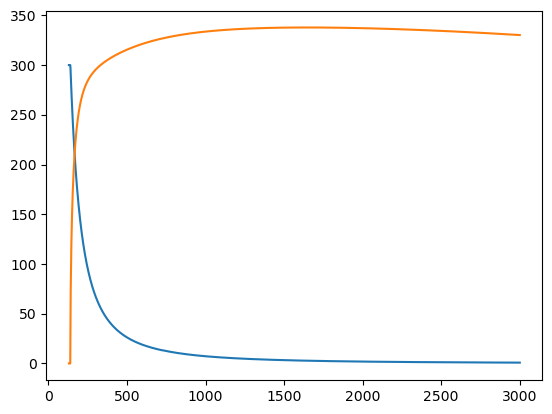

In [7]:
plt.plot(μI_lin, ϕ0_min)
plt.plot(μI_lin, ρ0_min)

In [8]:
pressure_list = np.array([Pressure(ϕ0_min[i], ρ0_min[i], 0, μI_lin[i]) for i in range(len(μI_lin))])/fπ**4
energy_density_list = np.array([Energy_Density(ϕ0_min[i], ρ0_min[i], 0, μI_lin[i]) for i in range(len(μI_lin))])/fπ**4
nI_list = np.array([nI(ϕ0_min[i], ρ0_min[i], 0, μI_lin[i]) for i in range(len(μI_lin))])

C:\Users\mathi\AppData\Local\Temp\ipykernel_10152\241863425.py:14: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral, err = integrate.quad(integrand, 0, Λ_cutoff)
C:\Users\mathi\AppData\Local\Temp\ipykernel_10152\241863425.py:14: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, err = integrate.quad(integrand, 0, Λ_cutoff)
C:\Users\mathi\AppData\Local\Temp\ipykernel_10152\241863425.py:14: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  

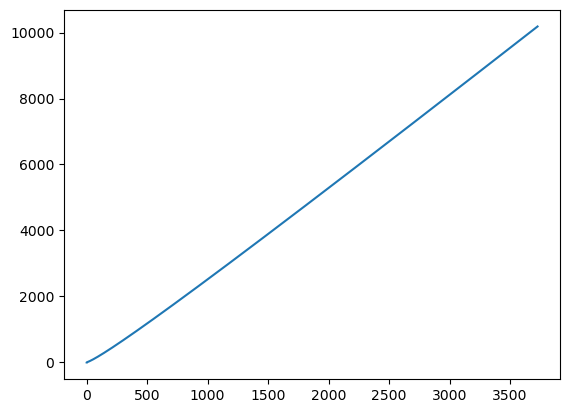

In [9]:
plt.plot(pressure_list, energy_density_list)
plt.show()

In [10]:
speed_of_sound = np.diff(pressure_list)/np.diff(energy_density_list)

In [11]:
print(speed_of_sound)

[-0.59056891 -0.98680164 -0.51484241 ...  0.35025313  0.35023673
  0.35022128]


In [13]:
np.savetxt('cs2.txt', speed_of_sound)
np.savetxt('muI.txt', μI_lin[1:])

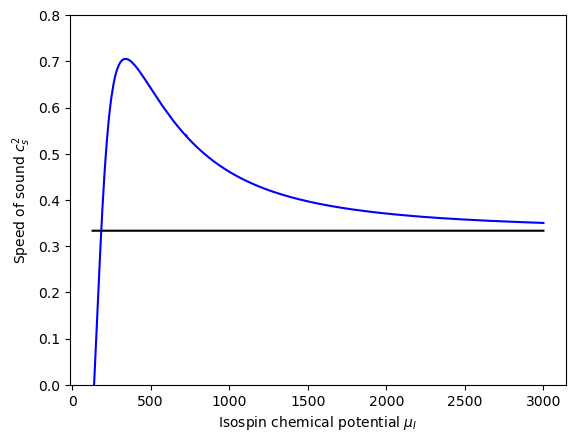

In [12]:
plt.xlabel("Isospin chemical potential " + r"$\mu_I$")
plt.ylabel("Speed of sound " + r"$c_s^2$")
plt.plot(μI_lin[1:], speed_of_sound, c="blue")
plt.plot(μI_lin, [1/3]*len(nI_list), c= "black")
plt.ylim(0,0.8)
plt.show()

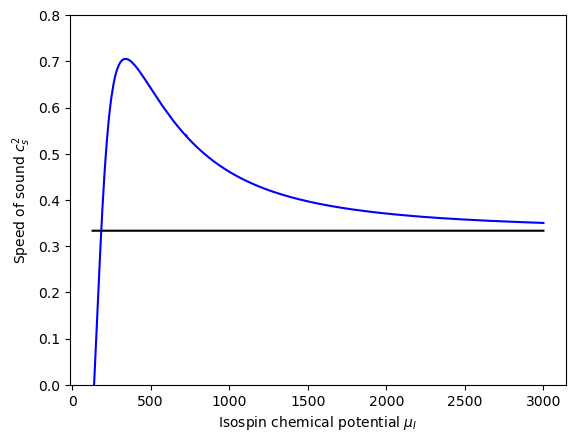

In [13]:
plt.xlabel("Isospin chemical potential " + r"$\mu_I$")
plt.ylabel("Speed of sound " + r"$c_s^2$")
plt.plot(μI_lin[1:], speed_of_sound, c="blue")
plt.plot(μI_lin, [1/3]*len(μI_lin), c= "black")
plt.ylim(0,0.8)
plt.show()

In [14]:
lattice_comparisson_data_32x48 = np.loadtxt("cs_32x48_MS_0.txt", dtype = float)
lattice_comparisson_data_24x32 = np.loadtxt("cs_24x32_MS_0.txt", dtype = float)

In [15]:
lattice_32x48_μ = lattice_comparisson_data_32x48[0::5]
lattice_32x48_cs = lattice_comparisson_data_32x48[1::5]
lattice_32x48_error1 = lattice_comparisson_data_32x48[2::5]
lattice_32x48_error2 = lattice_comparisson_data_32x48[3::5]
lattice_32x48_error3 = lattice_comparisson_data_32x48[4::5]

In [16]:
lattice_24x32_μ = lattice_comparisson_data_24x32[0::5]
lattice_24x32_cs = lattice_comparisson_data_24x32[1::5]
lattice_24x32_error1 = lattice_comparisson_data_24x32[2::5]
lattice_24x32_error2 = lattice_comparisson_data_24x32[3::5]
lattice_24x32_error3 = lattice_comparisson_data_24x32[4::5]

(0.0, 0.8)

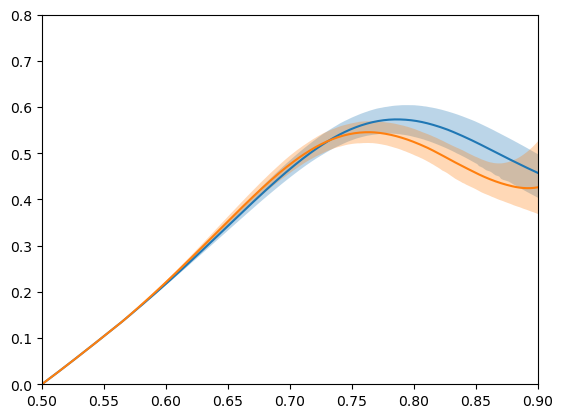

In [17]:
plt.plot(lattice_32x48_μ, lattice_32x48_cs)
#plt.plot(lattice_32x48_μ, lattice_32x48_cs_min)
plt.plot(lattice_24x32_μ, lattice_24x32_cs)
plt.fill_between(lattice_32x48_μ, lattice_32x48_cs-(lattice_32x48_error1**2 + lattice_32x48_error3**2)**(1/2), lattice_32x48_cs + (lattice_32x48_error1**2 + lattice_32x48_error2**2)**(1/2),alpha=.3)
plt.fill_between(lattice_24x32_μ, lattice_24x32_cs-(lattice_24x32_error1**2 + lattice_24x32_error3**2)**(1/2), lattice_24x32_cs + (lattice_24x32_error1**2 + lattice_24x32_error2**2)**(1/2),alpha=.3)
plt.xlim(0.5, 0.9)
plt.ylim(0, 0.8)

NLO data

In [18]:
cslo3_data = np.loadtxt("cslo3.dat", dtype = float)
csnlo3_data = np.loadtxt("csnlo3.dat", dtype = float)
elo3_data = np.loadtxt("elo3.dat", dtype = float)

In [19]:
print(elo3_data)

[[1.00000000e+00 0.00000000e+00]
 [1.00050000e+00 1.99900075e-03]
 [1.00100000e+00 3.99600599e-03]
 ...
 [2.09850000e+00 2.86122864e+00]
 [2.09900000e+00 2.86244027e+00]
 [2.09950000e+00 2.86365204e+00]]


In [20]:
μImπ_lo_data = [i[0] for i in cslo3_data]
cslo_data = [i[1] for i in cslo3_data]

μImπ_nlo_data = [i[0] for i in csnlo3_data]
csnlo_data = [i[1] for i in csnlo3_data]

μImπ_elo_data = [i[0] for i in elo3_data]
elo_data = [i[1] for i in elo3_data]

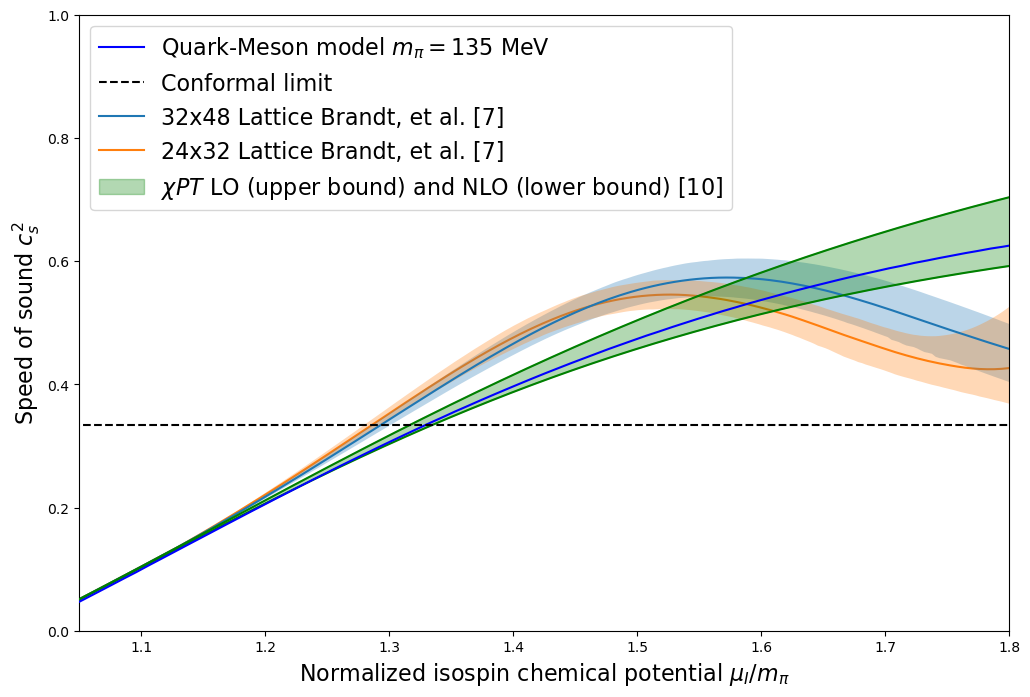

In [86]:
fig = plt.figure(figsize=(12,8))
plt.plot(μI_lin[1:]/mπ, speed_of_sound, c="blue", label="Quark-Meson model " + r'$m_\pi=135$' + ' MeV',zorder=5)
plt.plot(μI_lin/mπ, [1/3]*len(nI_list), linestyle = 'dashed', c= "black", label="Conformal limit",zorder=6)
plt.plot(μImπ_lo_data, cslo_data, color='green',zorder=4)
plt.plot(μImπ_nlo_data, csnlo_data, color='green',zorder=4)



plt.plot(2*lattice_32x48_μ, lattice_32x48_cs,label='32x48 Lattice Brandt, et al. [7]',zorder=2)
plt.plot(2*lattice_24x32_μ, lattice_24x32_cs, label = '24x32 Lattice Brandt, et al. [7]',zorder=1)
plt.fill_between(2*lattice_32x48_μ, lattice_32x48_cs-(lattice_32x48_error1**2 + lattice_32x48_error3**2)**(1/2), lattice_32x48_cs + (lattice_32x48_error1**2 + lattice_32x48_error2**2)**(1/2),alpha=.3)
plt.fill_between(2*lattice_24x32_μ, lattice_24x32_cs-(lattice_24x32_error1**2 + lattice_24x32_error3**2)**(1/2), lattice_24x32_cs + (lattice_24x32_error1**2 + lattice_24x32_error2**2)**(1/2),alpha=.3)
plt.fill(
    np.append(μImπ_lo_data, μImπ_nlo_data[::-1]),
    np.append(cslo_data, csnlo_data[::-1]),
    c='green',
    alpha=0.3,
    label =r'$\chi PT$' + ' LO (upper bound) and NLO (lower bound) [10]' 
)
#plt.fill_between(2*lattice_32x48_μ, lattice_32x48_cs-lattice_32x48_error, lattice_32x48_cs+lattice_32x48_error,alpha=.3,zorder=2)
#plt.fill_between(2*lattice_24x32_μ, lattice_24x32_cs-lattice_24x32_error, lattice_24x32_cs+lattice_24x32_error,alpha=.3,zorder=1)
#plt.plot(2*μI_data[1:], speed_of_sound_data, label='Lattice', color='green')
plt.ylim(0, 1)
plt.xlim(1.05,1.8)
plt.legend(fontsize=16)
plt.xlabel('Normalized isospin chemical potential 'r'$\mu_I/m_\pi$', fontsize=16)
plt.ylabel('Speed of sound 'r'$c_s^2$', fontsize=16)
plt.savefig("cs_iso_compare_v1.pdf")
plt.show()

In [22]:
import h5py

Keys: <KeysViewHDF5 ['chemical_potential', 'lattice', 'mixed_model']>
<KeysViewHDF5 ['energy_density', 'pressure', 'speed_of_sound2']>
<HDF5 dataset "speed_of_sound2": shape (300, 2000), type "<f8">


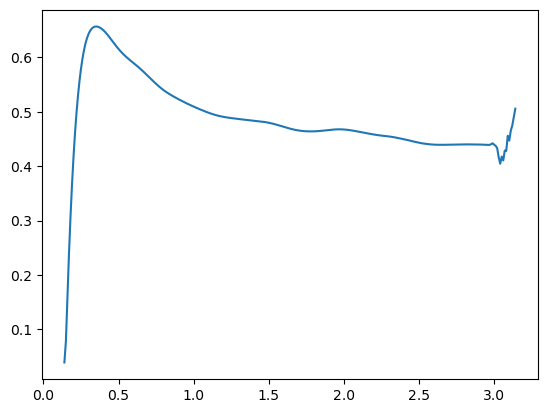

In [23]:
with h5py.File("publish_data.h5", "r") as data:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % data.keys())
    dset = data['lattice'].keys()
    print(dset)
    print(data['lattice/speed_of_sound2'])
    μ_data = list(data['chemical_potential'])
    μ_data_log = np.array([1000*μi for μi in μ_data])
    cs_data = list(data['lattice/speed_of_sound2'])
    cs_data_tot = [[cs_data[i][j] for i in range(len(cs_data))] for j in range(2000)]
    plt.plot(μ_data, cs_data_tot[0])

In [103]:
cs_data_abbot_avg = np.mean(cs_data_tot,axis=0)
cs_data_abbot_std = np.std(cs_data_tot,axis=0)

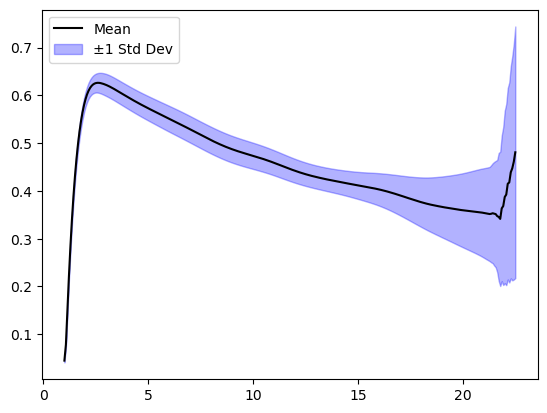

In [105]:
#plt.plot(np.mean(cs_data_tot,axis=0))
plt.plot(μ_data_log/139.57039, cs_data_abbot_avg, color='black', label="Mean")
plt.fill_between(μ_data_log/139.57039, cs_data_abbot_avg - cs_data_abbot_std , cs_data_abbot_avg + cs_data_abbot_std , color='blue', alpha=0.3, label="±1 Std Dev")

plt.legend()
plt.show()

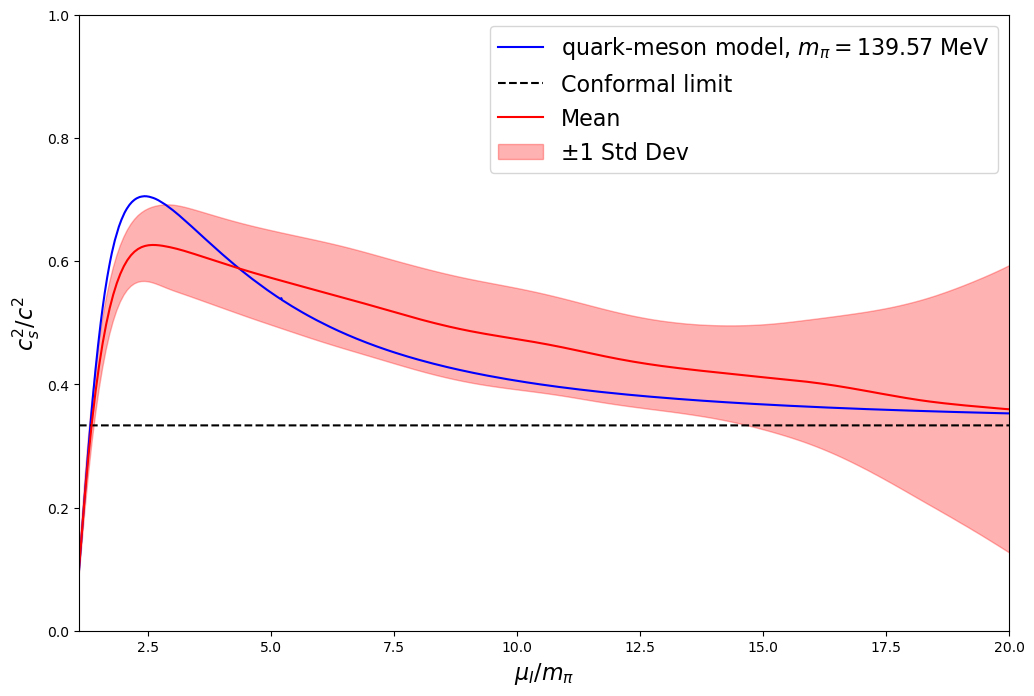

In [107]:
fig = plt.figure(figsize=(12,8))
import matplotlib.patches as patches
plt.plot(μI_lin[1:]/139.57039, speed_of_sound, c="blue", label="quark-meson model, " + r'$m_\pi = 139.57$' + ' MeV',zorder=2)
#plt.plot(μI_lin, [1/3]*len(nI_list), linestyle = 'dashed', c= "black", label="Conformal limit",zorder=6)
plt.plot(μI_lin/139.57039, [1/3]*len(nI_list), linestyle = 'dashed', c= "black", label="Conformal limit")
plt.plot(μ_data_log/139.57039, cs_data_abbot_avg, color='red', label="Mean")
plt.fill_between(μ_data_log/139.57039, cs_data_abbot_avg - 3*cs_data_abbot_std , cs_data_abbot_avg + 3*cs_data_abbot_std , color='red', alpha=0.3, label="±1 Std Dev")

#Old abbot lines
#plt.plot(μ_data_log/139.57039, cs_data_tot[100], c='red',alpha = 0.9, label="LQCD Abbot, et al.",zorder=1)
#for i in range(0,2000):
#    plt.plot(μ_data_log/139.57039, cs_data_tot[i], c='red',alpha=0.01,zorder=1)
plt.legend(fontsize=16)

plt.xlim(1.1,20)
plt.ylim(0, 1)
plt.xlabel(r'$\mu_I/m_\pi$', fontsize=16)
plt.ylabel(r'$c_s^2/c^2$', fontsize=16)
plt.savefig("cs_iso_compare_v2.pdf")
plt.show()

In [25]:
from mpmath import *

In [26]:
L1r = 1*10**(-3)
L2r = 1.6*10**(-3)
L3r = -3.8*10**(-3)
L4r = 0.0*10**(-3)
L5r = 1.2*10**(-3)
L6r = 0.0*10**(-3)
L8r = 0.5*10**(-3)

m_pi = 139.57
m_pi0 = 140.25
m_K0 = 530.55
f = 78.18
Lambda = 770

m_K0tilde = np.sqrt(m_K0**2 - 1/2*m_pi0**2)
m_eta0 = np.sqrt(1/3*(4*m_K0**2 - m_pi0**2))

def m_2(mu_I):
    return np.sqrt(mu_I**2*(1 - m_pi0**4/(mu_I**4)))

def m_3(mu_I):
    return np.sqrt(mu_I**2)

def m_4tilde(mu_I):
    return np.sqrt(m_K0tilde**2 + 1/4*mu_I**2*(1 + m_pi0**4/mu_I**4))
    
def m_8(mu_I):
    return np.sqrt(m_eta0**2 - 1/3*m_pi0**2*(1 - m_pi0**2/mu_I**2))

In [27]:
def Pressure_LO(mu_I):
    fpi = 92.07
    mpi = 139.57
    mpi0 = mpi
    
    term1 = 0.5 * fpi**2 * mu_I**2 * (1 - mpi**2 / mu_I**2)
    term2 = -0.5 * fpi**2 * (mpi0**4 / mpi**2) * (1 - mpi**2 / mu_I**2)
    return term1 + term2

def EoS_LO(mu_I_lin):
    Pressure_list = np.array([Pressure_LO(mu_Ii) for mu_Ii in mu_I_lin])
    number_density_list = np.diff(Pressure_list)/np.diff(mu_I_lin)
    return Pressure_list[1:], -Pressure_list[1:] + mu_I_lin[1:]*number_density_list 

def Pressure_NLO(mu_I):
    
    term1 = 0.5 * f**2 * mu_I**2 * (1 - m_pi**2 / mu_I**2)
    term2 = -0.5 * f**2 * (m_pi0**4 / m_pi**2) * (1 - m_pi**2 / mu_I**2)
    term3 = (4*L1r + 4*L2r + 2*L3r + 1/(4*(4*np.pi)**2) * (np.log(Lambda**2 / m_2(mu_I)**2) + np.log(Lambda**2 / m_3(mu_I)**2) + 1/4 * np.log(Lambda**2 / m_4tilde(mu_I)**2) + 9/8)) * mu_I**4
    
    term4 = -(32*L6r + 1/((4*np.pi)**2) * (np.log(Lambda**2 / m_K0**2) + 2/9 * np.log(Lambda**2 / m_eta0**2) + 11/18)) * m_pi0**2 * m_K0tilde**2
    
    term5 = -(8*L1r + 8*L2r + 4*L3r - 8*L4r - 4*L5r + 16*L6r + 8*L8r) * m_pi0**4
    term6 = (1/(4*(4*np.pi)**2) * (3*np.log(Lambda**2 / m_pi0**2) + np.log(Lambda**2 / m_K0tilde**2) - 0.5*np.log(Lambda**2 / m_4tilde(mu_I)**2) + 1/9 * np.log(Lambda**2 / m_eta0**2) + 65/36)) * m_pi0**4
    
    term7 = (1/((4*np.pi)**2) * (np.log(m_K0**2 / m_4tilde(mu_I)**2) + 4/9 * np.log(m_eta0**2 / m_8(mu_I)**2))) * m_K0tilde**4
    
    term8 = -(8*L4r - 32*L6r - 1/(2*(4*np.pi)**2) * (np.log(Lambda**2 / m_4tilde(mu_I)**2) + 4/9 * np.log(Lambda**2 / m_8(mu_I)**2) + 13/18)) * (m_pi0**4 * m_K0tilde**2 / mu_I**2)
    
    term9 = (4*L1r + 4*L2r + 2*L3r - 8*L4r - 4*L5r + 16*L6r + 8*L8r) * m_pi0**8 / mu_I**4
    term10 = (1/(144*(4*np.pi)**2) * (36*np.log(Lambda**2 / m_2(mu_I)**2) + 9*np.log(Lambda**2 / m_4tilde(mu_I)**2) + 4*np.log(Lambda**2 / m_8(mu_I)**2) - 47/2)) * m_pi0**8 / mu_I**4
    
    term11 = (8*L4r + 1/(2*(4*np.pi)**2) * (np.log(Lambda**2 / m_4tilde(mu_I)**2) + 0.5)) * m_K0tilde**2 * mu_I**2
    
    term12 = -5 * m_pi0**12 / ((12 * (4*np.pi)**2 * (mu_I**4 - m_pi0**4)*mu_I**4)) * np.real(hyp3f2(1, 1, 7/2, 4, 5, -4 * m_pi0**4 / (mu_I**4 - m_pi0**4)))
    #term13 = (-4 * m_pi0**4 / (mu_I**4 - m_pi0**4))
    
    return term1 + term2 + term3 + term4 + term5 + term6 + term7 + term8 + term9 + term10 + term11 + term12 - 15266535.3013132 

def EoS_NLO(mu_I_lin):
    Pressure_list = np.array([Pressure_NLO(mu_Ii) for mu_Ii in mu_I_lin])
    number_density_list = np.diff(Pressure_list)/np.diff(mu_I_lin)
    return Pressure_list[1:], -Pressure_list[1:] + mu_I_lin[1:]*number_density_list 


In [28]:
mu_I_lin = np.linspace(141, 350, 500)
Pressure_vals_LO, energy_den_vals_LO = EoS_LO(mu_I_lin)
Pressure_vals_NLO, energy_den_vals_NLO = EoS_NLO(mu_I_lin)
cs_vals_LO = np.diff(Pressure_vals_LO)/np.diff(energy_den_vals_LO)
cs_vals_NLO = np.array(np.diff(Pressure_vals_NLO)/np.diff(energy_den_vals_NLO),dtype=float)

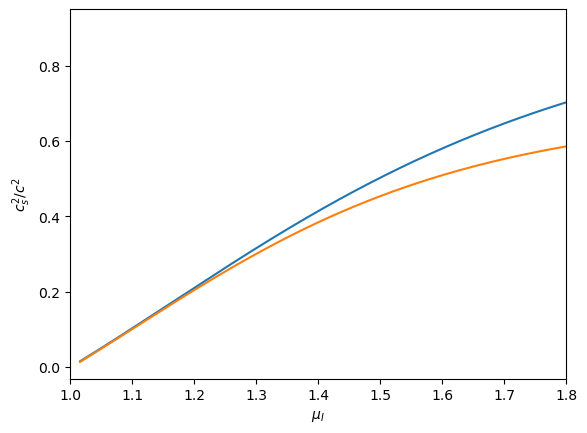

In [29]:
plt.xlabel(r'$\mu_I$')
plt.ylabel(r'$c_s^2/c^2$')
plt.plot(mu_I_lin[2:]/m_pi, cs_vals_LO)
plt.plot(mu_I_lin[2:]/m_pi, cs_vals_NLO)
plt.xlim(1, 1.8)
plt.show()

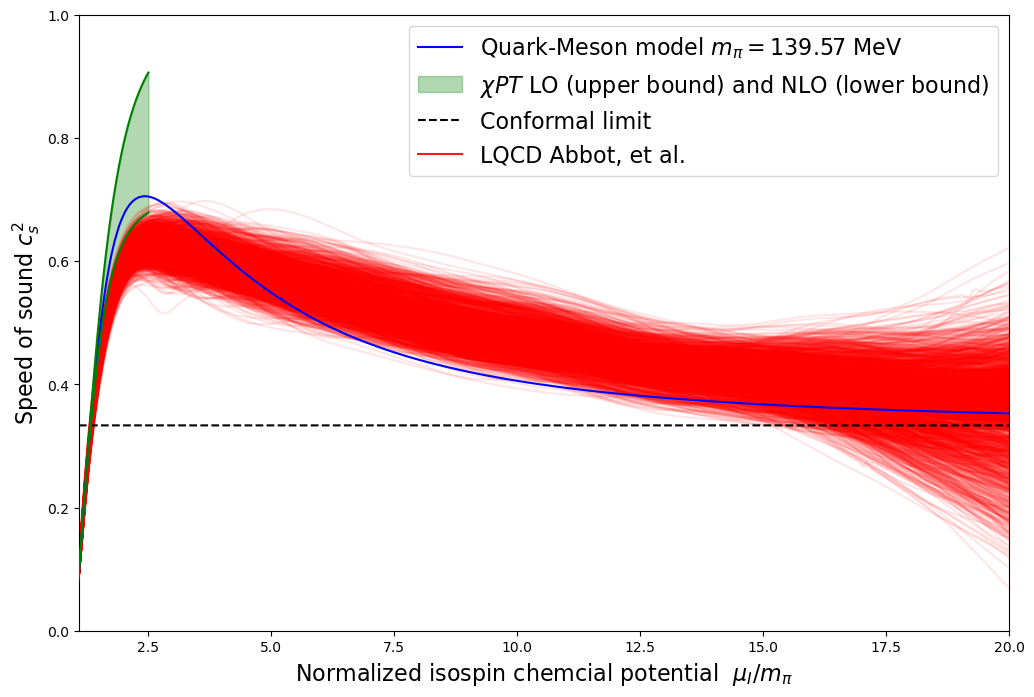

In [70]:
fig = plt.figure(figsize=(12,8))
import matplotlib.patches as patches
plt.plot(μI_lin[1:]/139.57039, speed_of_sound, c="blue", label="Quark-Meson model " + r'$m_\pi =  139.57$' + ' MeV',zorder=2)
plt.plot(mu_I_lin[2:]/m_pi, cs_vals_LO, c='green', zorder=3)
plt.plot(mu_I_lin[2:]/m_pi, cs_vals_NLO, c='green', zorder=3)
plt.fill_between(mu_I_lin[2:]/m_pi, cs_vals_LO, cs_vals_NLO, color='green', alpha=0.3, label = r'$\chi PT$' + ' LO (upper bound) and NLO (lower bound)')
plt.plot(μI_lin/139.57039, [1/3]*len(nI_list), linestyle = 'dashed', c= "black", label="Conformal limit")
plt.plot(μ_data_log/139.57039, cs_data_tot[100], c='red',alpha = 0.9, label="LQCD Abbot, et al.",zorder=1)
for i in range(0,2000):
    plt.plot(μ_data_log/139.57039, cs_data_tot[i], color='red',alpha=0.1,zorder=1)
plt.legend(fontsize=16)

plt.xlim(1.1,20)
plt.ylim(0, 1)
plt.xlabel('Normalized isospin chemcial potential  'r'$\mu_I/m_\pi$', fontsize=16)
plt.ylabel('Speed of sound 'r'$c_s^2$', fontsize=16)
plt.savefig("cs_iso_compare_v2.pdf")
plt.show()

In [71]:
cs_Fukushima_data = np.loadtxt("cs2_iso.dat", dtype =float, delimiter=',')

In [72]:
μI_Fukushima_data = [i[0] for i in cs_Fukushima_data]
cs1_Fukushima_data = [i[1] for i in cs_Fukushima_data]
cs2_Fukushima_data = [i[2] for i in cs_Fukushima_data]
cs4_Fukushima_data = [i[3] for i in cs_Fukushima_data]

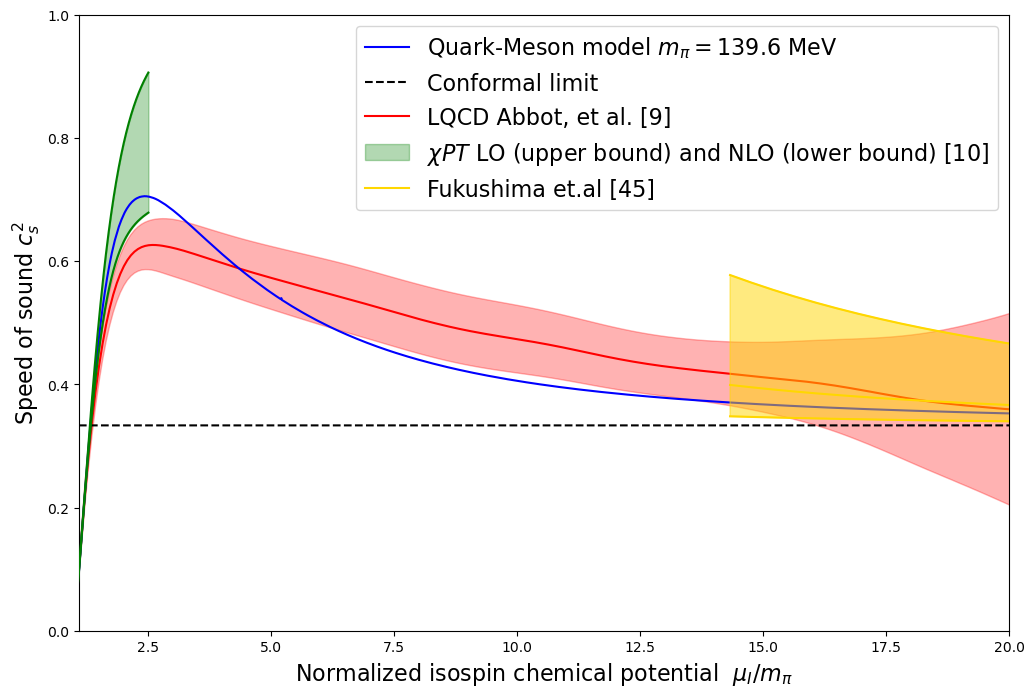

In [111]:
fig = plt.figure(figsize=(12,8))
import matplotlib.patches as patches
plt.plot(μI_lin[1:]/139.57039, speed_of_sound, c="blue", label="Quark-Meson model " + r'$m_\pi =  139.6$' + ' MeV',zorder=2)
plt.plot(mu_I_lin[2:]/m_pi, cs_vals_LO, c='green', zorder=3)
plt.plot(mu_I_lin[2:]/m_pi, cs_vals_NLO, c='green', zorder=3)

plt.plot(μI_lin/139.57039, [1/3]*len(nI_list), linestyle = 'dashed', c= "black", label="Conformal limit")
plt.plot(μ_data_log/139.57039, cs_data_abbot_avg, color='red', label="LQCD Abbot, et al. [9]",zorder=1)
plt.fill_between(μ_data_log/139.57039, cs_data_abbot_avg - 2*cs_data_abbot_std , cs_data_abbot_avg + 2*cs_data_abbot_std , color='red', alpha=0.3,zorder=1)

#Old abbot plot 
#plt.plot(μ_data_log/139.57039, cs_data_tot[100], c='red',alpha = 0.9, label="LQCD Abbot, et al. [9]",zorder=1)
#for i in range(0,2000):
#    plt.plot(μ_data_log/139.57039, cs_data_tot[i], color='red',alpha=0.1,zorder=1)
plt.fill_between(mu_I_lin[2:]/m_pi, cs_vals_LO, cs_vals_NLO, color='green', alpha=0.3, label = r'$\chi PT$' + ' LO (upper bound) and NLO (lower bound) [10]')
plt.fill_between(np.array(μI_Fukushima_data)*1000/139.57039, cs1_Fukushima_data,cs4_Fukushima_data, color='gold', alpha=0.5, zorder =6)
plt.plot(np.array(μI_Fukushima_data)*1000/139.57039, cs2_Fukushima_data,color ='gold', label='Fukushima et.al [45]')
plt.plot(np.array(μI_Fukushima_data)*1000/139.57039, cs1_Fukushima_data,color ='gold')
plt.plot(np.array(μI_Fukushima_data)*1000/139.57039, cs4_Fukushima_data,color ='gold')
plt.legend(fontsize=16)

plt.xlim(1.1,20)
plt.ylim(0, 1)
plt.xlabel('Normalized isospin chemical potential  'r'$\mu_I/m_\pi$', fontsize=16)
plt.ylabel('Speed of sound 'r'$c_s^2$', fontsize=16)
plt.savefig("cs_iso_compare_v2.pdf")
plt.show()

Finding peak of QM model cs2

In [88]:
cs2_QM_diff = np.diff(speed_of_sound)/np.diff(μI_lin[1:]/139.57039)

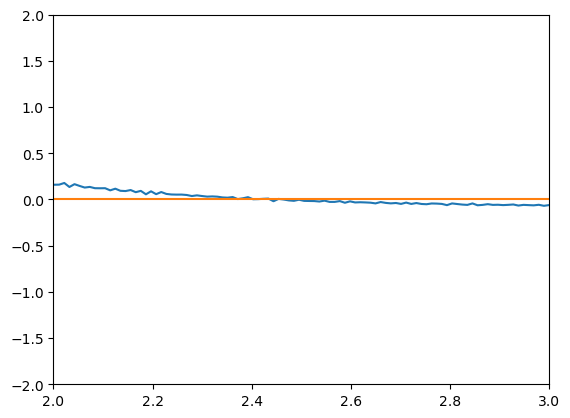

In [99]:
plt.plot(μI_lin[2:]/139.57039, cs2_QM_diff)
plt.plot(μI_lin[2:]/139.57039, [0]*len(μI_lin[2:]))
plt.xlim(2,3)
plt.ylim(-2,2)
plt.show()